In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import random

words = open('cleanednames.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
dataSetCount = len(words)

In [4]:
dataSetItemMax = max(len(w) for w in words)

In [5]:
d = {}
sorted(d.items(), key = lambda kv: kv[1], reverse = True)
N = torch.zeros((27,27), dtype=torch.int32)

In [25]:
chars = sorted(list(set(''.join(words))))
stoj = {i:j+1 for j,i in enumerate(chars)}
stoj['.'] = 0
jots = {j:i for i,j in stoj.items()}

In [26]:
#adding the counts for every bigram in the data set to tensor N
for w in words:
    bucket = ['.'] + list(w) + ['.']
    for i in range(len(bucket)-1):
        jx1, jx2 = stoj[bucket[i]], stoj[bucket[i+1]]
        N[jx1, jx2] += 1

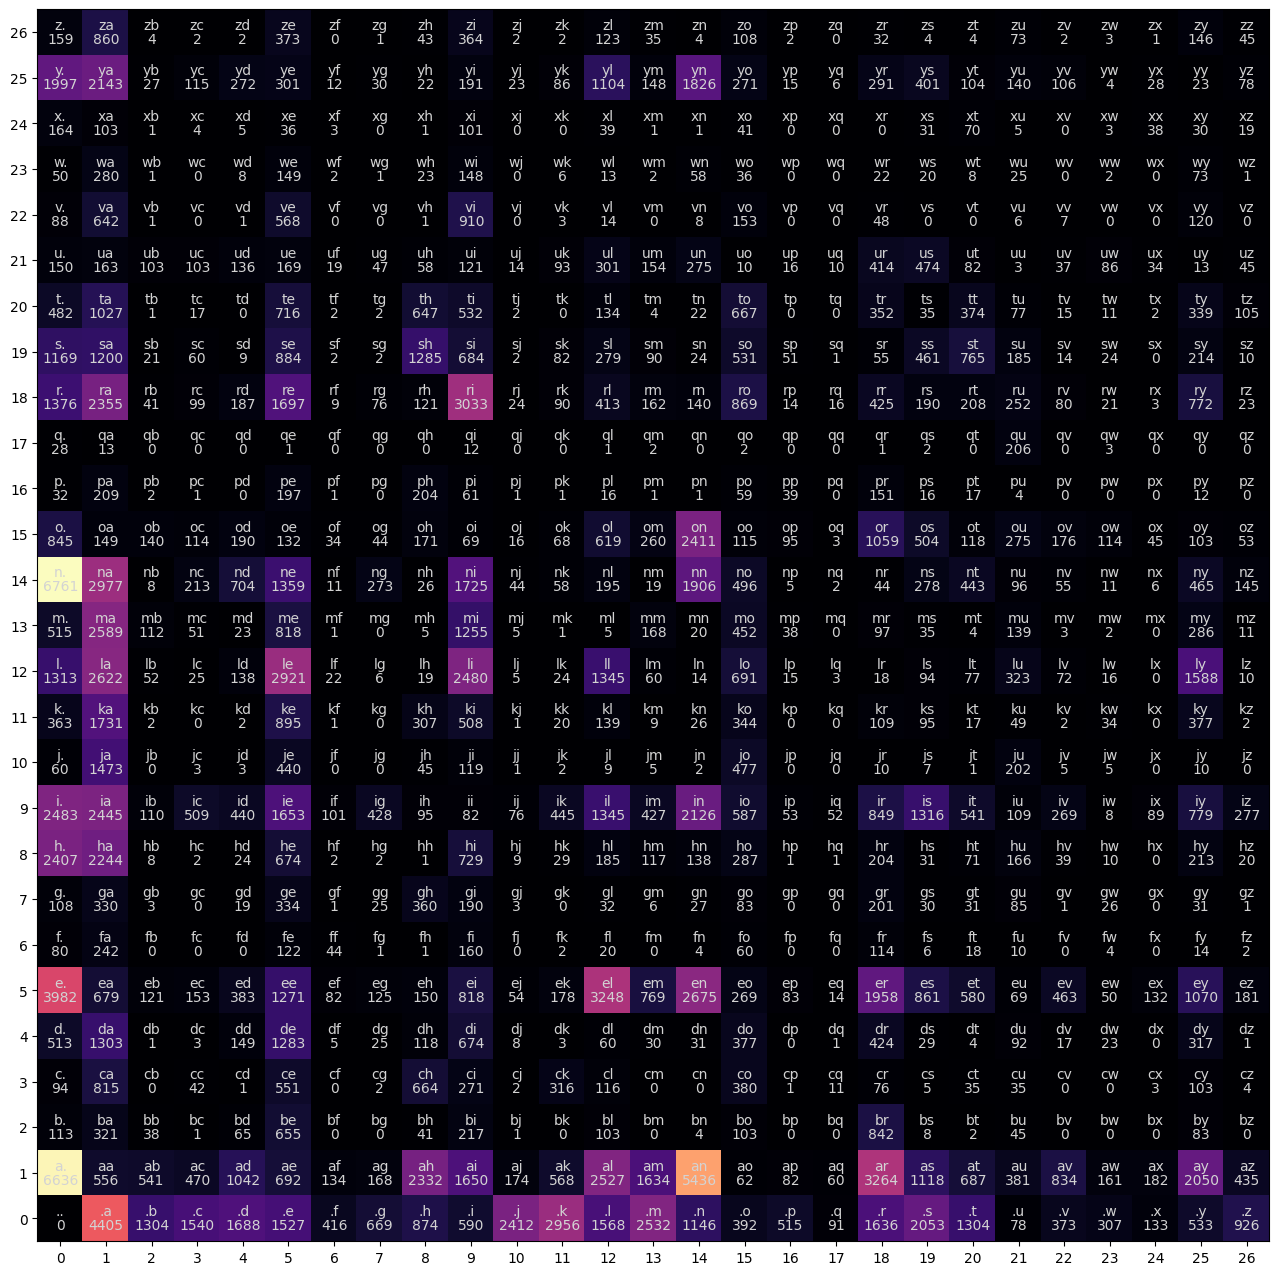

In [22]:
#visualizing the full tensor and each bigram count
plt.figure(figsize=(16,16))
plt.xticks(range(27))
plt.yticks(range(27))
plt.imshow(N, cmap='magma')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
for i in range(27):
    for j in range(27):
        chtostr = jots[i] + jots[j]
        plt.text(j, i, chtostr, ha='center', va='bottom', color='lightgrey')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='lightgrey')

In [10]:
p = N[0].float()
p /= sum(p)
p

tensor([0.0000, 0.1378, 0.0408, 0.0482, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0185, 0.0755, 0.0925, 0.0490, 0.0792, 0.0358, 0.0123, 0.0161, 0.0028,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [11]:
sample = torch.multinomial(p, num_samples=1, replacement=True).item()
sample

9

In [12]:
PM = (N+1).float() #ProbabilityMatrix
PM = PM / PM.sum(1, keepdim=True)

In [13]:
#generates novel name combinations
rand21 = torch.Generator().manual_seed(2147483647)
count = 0
while count < 20:
    index = 0
    output = []
    while True:
        p = PM[index]
        index = torch.multinomial(p, num_samples=1, replacement=True, generator=rand21).item()
        output.append(jots[index])
        if index == 0:
            break
    if len(output) <= 3 or len(output) >= 13:
        continue
    count += 1
    print(''.join(output).strip('.').capitalize())

Junide
Janasah
Cony
Kohin
Tolian
Juee
Core
Yaenon
Anaasn
Ssorionsush
Dgossmitan
Pann
That
Janreli
Isa
Dyn
Cararr
Jen
Janarta
Maly


In [14]:
#checks for changes to the output given additive smoothing, WIP
'''PM = (N).float() #ProbabilityMatrix
PM = PM / PM.sum(1, keepdim=True)
SPM = (N+1).float() #ProbabilityMatrix
SPM = SPM / SPM.sum(1, keepdim=True)

rand21 = torch.Generator().manual_seed(2147483647)
count = 0
sof = open('smoothingoutput.txt','w+')
so = sof.read().splitlines()
nsof = open('nosmoothingoutput.txt','w+')
nso = nsof.read().splitlines()
output = []
soutput = []
while count < 100:
    index = 0
    output = []
    soutput = []
    while True:
        p = PM[index]
        index = torch.multinomial(p, num_samples=1, replacement=True, generator=rand21).item()
        output.append(jots[index])
        if index == 0:
            break
    index = 0
    while True:
        sp = SPM[index]
        index = torch.multinomial(sp, num_samples=1, replacement=True, generator=rand21).item()
        soutput.append(jots[index])
        if index == 0:
            break
    count += 1
    sof.write(''.join(soutput).strip('.').capitalize() + '\n')
    nsof.write(''.join(output).strip('.').capitalize() + '\n')'''

"PM = (N).float() #ProbabilityMatrix\nPM = PM / PM.sum(1, keepdim=True)\nSPM = (N+1).float() #ProbabilityMatrix\nSPM = SPM / SPM.sum(1, keepdim=True)\n\nrand21 = torch.Generator().manual_seed(2147483647)\ncount = 0\nsof = open('smoothingoutput.txt','w+')\nso = sof.read().splitlines()\nnsof = open('nosmoothingoutput.txt','w+')\nnso = nsof.read().splitlines()\noutput = []\nsoutput = []\nwhile count < 100:\n    index = 0\n    output = []\n    soutput = []\n    while True:\n        p = PM[index]\n        index = torch.multinomial(p, num_samples=1, replacement=True, generator=rand21).item()\n        output.append(jots[index])\n        if index == 0:\n            break\n    index = 0\n    while True:\n        sp = SPM[index]\n        index = torch.multinomial(sp, num_samples=1, replacement=True, generator=rand21).item()\n        soutput.append(jots[index])\n        if index == 0:\n            break\n    count += 1\n    sof.write(''.join(soutput).strip('.').capitalize() + '\n')\n    nsof.writ

In [20]:
#evaluating the overall quality of the model
totalLogLikelihood = 0.0
mostFitName = 'str'
leastFitName = 'str'
maximaLikelihood = 1 #Keep in mind, a lower log likelihood indicates higher fitness, the maxima Likelihood is the least likely spelling
minimaLikelihood = 10
n = 0

print('First 3 words:')
for w in words:
    bucket = ['.'] + list(w) + ['.']
    wordLikelihood = 0
    for i in range(len(bucket)-1):
        jx1, jx2 = stoj[bucket[i]], stoj[bucket[i+1]]
        probability = PM[jx1,jx2].item()
        bigramLikelihood = torch.log(PM[jx1,jx2])
        totalLogLikelihood -= bigramLikelihood
        wordLikelihood -= bigramLikelihood.item()
        n += 1
        if n < 17:
            print(f'{bucket[i]}{bucket[i+1]} -> {round((probability*100),1):4}%  Likelihood of bigram: {round(bigramLikelihood.item(),3)}')
    if (wordLikelihood/(len(bucket)-1)) < minimaLikelihood:
        minimaLikelihood = (wordLikelihood/(len(bucket)-1))
        mostFitName = ''.join(bucket)
    elif (wordLikelihood/(len(bucket)-1)) > maximaLikelihood:
        maximaLikelihood = (wordLikelihood/(len(bucket)-1))
        leastFitName = ''.join(bucket)
print(f'Most likely name spelling: {mostFitName.strip(".").capitalize()}     Normalized Log Likelihood: {minimaLikelihood:.4f}')
print(f'Least likely name spelling: {leastFitName.strip(".").capitalize()}   Normalized Log Likelihood: {maximaLikelihood:.4f}')
print(f'Normalized loglikelihood of entire dataset: {totalLogLikelihood/n:.5f}')

First 3 words:
.e ->  4.8%  Likelihood of bigram: -3.042
em ->  3.8%  Likelihood of bigram: -3.279
mm ->  2.5%  Likelihood of bigram: -3.674
ma -> 38.9%  Likelihood of bigram: -0.945
a. -> 19.6%  Likelihood of bigram: -1.631
.o ->  1.2%  Likelihood of bigram: -4.4
ol ->  7.8%  Likelihood of bigram: -2.551
li -> 17.7%  Likelihood of bigram: -1.729
iv ->  1.5%  Likelihood of bigram: -4.184
vi -> 35.1%  Likelihood of bigram: -1.048
ia -> 13.8%  Likelihood of bigram: -1.98
a. -> 19.6%  Likelihood of bigram: -1.631
.a -> 13.8%  Likelihood of bigram: -1.983
av ->  2.5%  Likelihood of bigram: -3.704
va -> 24.8%  Likelihood of bigram: -1.396
a. -> 19.6%  Likelihood of bigram: -1.631
Most likely name spelling: Jan     Normalized Log Likelihood: 1.5231
Least likely name spelling: Hajj   Normalized Log Likelihood: 4.2471
Normalized loglikelihood of entire dataset: 2.45367
